# Python Imports/Libraries/

In [91]:
# 1. Basic Python Imports
import pandas as pd
import numpy as np
import pickle as pi
import os
from pathlib import Path

# 2. API PULL|
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
from defillama import DefiLlama

# 3. API Keys
from dotenv import load_dotenv

# 4. APIs
# 4.1  Pandas_Datareader
import pandas_datareader.data as web
from pandas_datareader import data, wb
import pandas_datareader as pdr
# 4.2 CoinMarketCap API
import coinmarketcapapi


# 5. Date Time
import datetime as dt
from datetime import datetime

# 6. Plotting
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas 
import hvplot.dask 

# Functions

<div class="alert alert-block alert-success">
<b>Function Philosophy</b> 
    <p>"Make small components, then hook them together to make larger components."</p>
<p>Each function does only one thing as reflected by their name.</p>
    <ol>
        <li>get_coinmarketcap_data()</li>
        <li>clean_coinmarketcap_data():</li>
        <li>filter_coinmarketcap_data():</li>
        <li>get_defiLLama_data():</li>
        <li>filter_defiLLama_data():</li>
        <li>cn_close_price_dfer():</li>
        <li>indx_close_price_xls():</li>
    </ol> 
</div>

In [92]:
def get_coinmarketcap_data():
    
    df = pd.DataFrame()
    
    
    # Using the API key to 
    cmc = coinmarketcapapi.CoinMarketCapAPI('3486d5cf-6e5b-443f-8f9a-140421f63bb3')
    
    # api pull
    data_listing = cmc.cryptocurrency_listings_latest(convert='USD')
    
    # 1. Create df and narrow columns
    # Note: Changing scientific notation of values in table 
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    
    # data comes in the form of a dictionary  will the the from_dict command
    df = pd.DataFrame.from_dict(data_listing.data)
    df = df[['name', 'symbol', 'date_added', 'quote']]
    
    return(df)


In [93]:
def clean_coinmarketcap_data(df= pd.DataFrame()):
    
    coin_dataset_df = df.copy()
    coin_dataset_df = pd.concat([coin_dataset_df, coin_dataset_df["quote"].apply(pd.Series)], axis=1)
    coin_dataset_df2 = pd.concat([coin_dataset_df, coin_dataset_df["USD"].apply(pd.Series)], axis=1)
    
    coin_dataset_df2 = coin_dataset_df2.drop(['quote','USD','volume_24h','volume_change_24h'], axis=1)
    
    return(coin_dataset_df2)


In [94]:
def filter_coinmarketcap_data(df1=pd.DataFrame()):
    
    cutoff_date = pd.Timestamp('2020-01-01')
    
    # Sorting values by largest market cap  
    crypto_df = df1
    crypto_df.sort_values(by='market_cap', ascending=False).head(10)
    crypto_df.loc['market_cap'] = crypto_df.loc[:, 'market_cap'].astype("float")
    
    # Eliminate the coins under $25B market cap - *** (had to lower this from 25B due to market volatility)  
    crypto_df_sorted = crypto_df.loc[crypto_df['market_cap'] >= 15000000000].copy()

    
    # Out of the remaining coins, eliminate coins that are newer than 2018 
    crypto_df_sorted_2 = crypto_df_sorted.loc[crypto_df_sorted['date_added'] < '2018-01-01'].copy()
    
    # Eliminate Stablecoins
    crypto_df_sorted_3 = crypto_df_sorted_2.loc[crypto_df_sorted_2['percent_change_90d'] < -1].copy()

    
    crypto_df_5 = crypto_df_sorted_3.loc[:, ["symbol", "price", "market_cap"]]

    
    return(crypto_df_5)

In [95]:
def get_defiLLama_data():
    
    
    
    # Initialize api client
    llama = DefiLlama()
    
    # Get all protocols data
    response = llama.get_all_protocols()
    
    # Get a protocol data
    response_1 = llama.get_protocol(name='uniswap')
    
    # Get historical values of total TVL
    response_2 = llama.get_historical_tvl()

    # Get protocol TVL
    response_3 = llama.get_protocol_tvl(name='uniswap')
    
    # Created a DataFrame to structure by relevant parameters
    defi_df = pd.DataFrame(response, 
                    columns =[
                        'name',
                        'symbol',
                        'tvl',
                        'fdv',
                        'mcap'
                    ])
    
    defi_df.set_index('symbol',inplace=True)
    
    return(defi_df)

In [96]:
def filter_defiLLama_data(data_df=pd.DataFrame()):
    
    
    defi_data_df =data_df.copy()
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    # Sorting values in descendinf order for. TVL's  
    defi_data_df.sort_values(by='tvl', ascending=False)
    
    # Filtering the dataframe to keep the protocols with over $7 Billion in Total Value Locked 
    # (TVL values had to be adjusted due to increased volatilty lately) 
    defi_data_df1= defi_data_df.loc[defi_data_df['tvl'] > 7000000000].copy()
    defi_data_df1.sort_values(by='mcap', ascending=False).head(10)

    defi_data_df2 = defi_data_df1.loc[defi_data_df1['mcap'] > 450000000].copy()
    defi_data_df2.sort_values(by='tvl', ascending=False).head(10)

    defi_data_df2['mcap_tvl_ratio'] = defi_data_df2['mcap'] / defi_data_df2['tvl'] 
    defi_data_df2.sort_values(by='mcap_tvl_ratio', ).head(10)

    defi_data_df3 = defi_data_df2.loc[defi_data_df2['mcap_tvl_ratio'] < 0.5].copy()
    defi_data_df3.sort_values(by='tvl', ascending=False).head(10)

    # Trying to find the most undervalued coins in the DeFi sector by calculating the Fully Diluted Value to Total Value Locked Ratio 
    defi_data_df3['fdv_tvl_ratio'] = defi_data_df3['fdv'] / defi_data_df3['tvl']
    
    return(defi_data_df3)
    
    

In [97]:
def cn_close_price_dfer(digital_asset=list):
    
    # Date information 
    startdate = datetime(2018,1,1)
    enddate = datetime.today() 
    
    # API PULL to get Data for coins
    adj_close = web.DataReader(digital_asset, 'yahoo',startdate, enddate)
    adj_close_df = adj_close.filter(like="Adj Close")
    adj_close_df.columns = adj_close_df.columns.droplevel(-2)
    
    return(adj_close_df)

In [98]:
def indx_close_price_xls(xlsfile_path=str):
    
    startdate = datetime(2018,1,1)
    
    
    dfs = pd.DataFrame()
    dfs= pd.read_excel(xlsfile_path, skiprows=6).dropna()
    dfs= dfs.rename({'Effective date ':'Date', 'S&P Cryptocurrency Broad Digital Market Index (USD)':'SPCBDM-USD'}, axis='columns')
    dfs= dfs.set_index('Date')
    dfs=dfs.dropna()
  
    return(dfs)

# CODE

<div class="alert alert-block alert-success">
<b>Black Box</b> 
<p> It's essential that the inner working of the script isn't visible in the central part of the notebook. Well-structured and compartmentalized code results in more straightforward maintenance and development. Also, better code readability never hindered collaboration between or onboarding new developers onto the project. We kept display statements to a minimum. They are present only where necessary. All function calls were made visible for the time being. We will revisit the visibility of function calls as the code grows.</p>
</div>

## Data Acquisition Coin-Set 1: Veteran Coins

In [99]:
# Create CoinMarketCap API df 
# Initialize DataFrame Variable
coinmarketcap_api_data = pd.DataFrame()

coinmarketcap_api_data = get_coinmarketcap_data()
clean_cmc_data = clean_coinmarketcap_data(coinmarketcap_api_data)
filter_cmc_data = filter_coinmarketcap_data(clean_cmc_data)

filter_cmc_data2 = filter_cmc_data.copy()
filter_cmc_data2 = filter_cmc_data2.set_index('symbol')
filter_cmc_data2['Pcnt_Glbl_CryptoMarkt'] = (filter_cmc_data['market_cap']/1320000000000)*100

# informing the user about coin selection
display(f"Here is some information about pur veteran coin selection:")
display(filter_cmc_data.head())


'Here is some information about pur veteran coin selection:'

,symbol,price,market_cap
0,BTC,31249.883,595022955126.593
1,ETH,2144.121,258994923513.056
4,BNB,311.835,50915475642.149
5,XRP,0.447,21602571817.647
6,ADA,0.596,20122742674.854


### Data Acquisition Coin-Set 2: DeFi-Coins

<div class="alert alert-block alert-info">
<p><b>Market Cap / Tot. Value Locked RATIO:</b> 
Theoretically the higher the TVL ratio is, the lower the value of an asset needs to be; however, this is not always the case when we look at reality. One of the easiest ways to implement the TVL ratio is to help determine if a DeFi asset is undervalued or overvalued, and this can be done by looking at the ratio. If it is under 1/closer to 0, it is undervalued in most cases.</p>
<p><b>Fully Dilluted Value / Tot. Value Locked RATIO:</b>
Similar to MCAP/TVL , FDV/TVL helps us tell the whole story and is also measured the same. The closer the ratio is to zero, typically the coin is viewed as undervalued. If it is over 1, it may be overvalued. Using both metrics helps provide us with the full picture.</p>
<p> <b>Understanding Fully Diluted Valuation (FDV)</b>
The Fully Diluted Valuation of a cryptocurrency or token is what the digital asset's market cap would be if all the coins or tokens in its total supply were issued. It’s calculated by multiplying the current market price of a particular coin or token with the maximum number of coins there will be.</b></p>
</div> 

In [100]:
# Create DefiLlama DataFrame to House the API pull Data
# Initialize DataFrame Variable
defi_data_df = pd.DataFrame()

defi_data_df = get_defiLLama_data()
filtered_defi_data = filter_defiLLama_data(defi_data_df)

display(filtered_defi_data)

,name,tvl,fdv,mcap,mcap_tvl_ratio,fdv_tvl_ratio
symbol,,,,,,
MKR,MakerDAO,10810655399.145,1587319814.000,1422734137.000,0.132,0.147
LDO,Lido,9145669610.137,1481740073.000,525957133.000,0.058,0.162
CRV,Curve,8955154953.842,4963733316.000,589027439.000,0.066,0.554
AAVE,AAVE,8873511373.460,1464465818.000,1255400048.000,0.141,0.165


### Importing Performance Data from yfinance

<div class="alert alert-block alert-info">
<b>Market Cap Size</b> 
<p>Market cap value is an indirect means of ascertaining both the risk and potential for growth of a digital asset
(cryptocurrency). Large-cap coins are comparatively less risker than mid or small-cap cryptos. However, they are also 
slower-growing than their small and mid-sized counterparts by that same token. Bitcoin accounts only for approximately 
40% of the total cryptocurrency market. Alternative coins capture the remaining 60%  of the market. So any crypto 
index fund should be sure to include the veteran and more stable coins, but the inclusion of alternative currencies 
offers significant potential for rapid growth.</p>
<p>
Our plan then is to include DeFI tokens in our crypto index fund. DeFi , or decentralized tokens, represent a diverse set of cryptocurrencies native to automated, decentralized platforms that use smart contracts. These provide users access to a suite of financial applications and services built on the blockchain, into which $75 billion worth of crypto has been locked. Decentralized finance (DeFi) tokens command a $114 billion market cap, a relatively small proportion of the overall $1.7 trillion cryptocurrency market. It has become one of the fastest-growing sectors in the industry, up from $89 billion the previous year.
    </p>
</div> 

In [101]:
# 1. Our set of coins 
# Based on set parameters as seen in the above code 

string = "-USD"
coin_list = filter_cmc_data['symbol'].to_list()
coin_list = [s + string for s in coin_list]


coin_list2 = filtered_defi_data.index.to_list()
coin_list2 = [s + string for s in coin_list2]

display(f"These are the coins in Group A: {coin_list}")
display(f"These are the coins in Group B: {coin_list2}")

"These are the coins in Group A: ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD']"

"These are the coins in Group B: ['MKR-USD', 'LDO-USD', 'CRV-USD', 'AAVE-USD']"

### Getting The Historical Data 

<div class="alert alert-block alert-warning">
<b>Historical Data :</b> 
<p>We chose 2018 as the starting point for when we should get performance data (close adjusted prices) for our coinsets. While that was fine for coin set A the veteran coins, many coins in Group B werent created yet. eventually all dataframes started at May 2021, because then we have all data from all coins. This does raise a question aboout how to cmpare performance data between sets. This will be explored in future iterations of this notebook.</p>
</div>

#### Creating two data sets w/ Index Data:

In [102]:
# Creating Coin Set A and Coin Set B Dataframes

In [112]:
# Get DataFrame of Coinset A
adj_close_df = cn_close_price_dfer(coin_list)

# Get DataFrame of Coinset B
adj_close_df2 = cn_close_price_dfer(coin_list2)

# Get DataFrame of Index/Indices
SPCBDM_path = Path("./Resources/PerformanceGraphExport.xls")
spcbdm_indx = indx_close_price_xls(SPCBDM_path)
spcbdm_indx = spcbdm_indx['2018-01-01':'2022-05-13']

# Concatenate the coin and index dataframes into one df
concat_adj_close_df = pd.concat([adj_close_df, spcbdm_indx], axis=1)
concat_adj_close_df = concat_adj_close_df.dropna()

concat_adj_close_df2 = pd.concat([adj_close_df2,spcbdm_indx], axis=1)
concat_adj_close_df2 = concat_adj_close_df2.dropna()

# Concatenate the Coin A and Coin B dataframes into one df
concat_adj_close_df3 = pd.concat([adj_close_df2, adj_close_df], axis=1)
concat_adj_close_df3= concat_adj_close_df3.dropna()
display(concat_adj_close_df3.head())
display(concat_adj_close_df3.tail())

#concat_adj_close_df2= concat_adj_close_df2.fillna(0)
#display(concat_adj_close_df.head())
#display(concat_adj_close_df.tail())

#display(concat_adj_close_df2.head())
#display(concat_adj_close_df2.tail())

Symbols,MKR-USD,LDO-USD,CRV-USD,AAVE-USD,BTC-USD,ETH-USD,BNB-USD,XRP-USD,ADA-USD
Date,,,,,,,,,
2021-01-05,762.640,1.763,0.687,116.454,33992.430,1100.006,41.735,0.227,0.258
2021-01-06,1023.964,1.757,0.730,115.001,36824.363,1207.112,42.166,0.251,0.332
2021-01-07,1064.732,1.418,0.719,114.940,39371.043,1225.678,43.449,0.326,0.300
2021-01-08,1045.074,1.503,0.695,111.703,40797.609,1224.197,42.395,0.323,0.306
2021-01-09,1578.580,0.846,0.764,117.667,40254.547,1281.077,43.933,0.327,0.333


Symbols,MKR-USD,LDO-USD,CRV-USD,AAVE-USD,BTC-USD,ETH-USD,BNB-USD,XRP-USD,ADA-USD
Date,,,,,,,,,
2022-05-11,1123.974,1.522,1.485,81.887,28936.355,2072.109,269.963,0.413,0.513
2022-05-12,1336.686,1.412,1.308,77.540,29047.752,1961.702,269.407,0.385,0.474
2022-05-13,1382.989,1.485,1.320,82.237,29283.104,2014.418,290.584,0.423,0.529
2022-05-14,1574.051,1.476,1.419,86.719,30101.266,2056.274,297.388,0.428,0.539
2022-05-15,1566.121,1.470,1.503,91.949,31304.590,2146.601,312.112,0.448,0.597


### Preparing DataFrames for Analysis: Coinset: A

In [105]:
# Variables
yearly_trading_days = 365 # For Crypto

# Data Frames Needed
#    1. Daily Returns
#    2. Average Annual Returns
#    3. Standard Deviation of Daily Returns
#    4. Sharpe Ratios
#    5. Correlation 


# Daily Returns
# Log of percentage change
df_daily_returns = concat_adj_close_df.pct_change()
df_daily_returns = df_daily_returns.dropna()


# Avg Annual Returns
avg_annual_return = df_daily_returns.mean() * yearly_trading_days
avg_annual_return.sort_values()



# Annual Returns STDDEV
df_daily_returns_stddev = df_daily_returns.std() * np.sqrt(yearly_trading_days)
df_daily_returns_stddev.sort_values()



# Sharpe Ratios
sharpe_ratios = avg_annual_return/df_daily_returns_stddev
sharpe_ratios.sort_values()


# Plotting the Sharpe Graphs for Coinset B (DeFi coins)

sharpe_ratios.sort_values().hvplot.bar(
    hover_color='pink',
    title="Coin Portfolio B & SPCBDM Sharpe Ratios"
).opts(
    width=700,
    yformatter='%.0f',
    #color="yellow",
    bgcolor="yellow",
    fontsize={
        'title': 15, 
        'labels': 12, 
    'xticks': 10, 
    'yticks': 10,},
    padding=0.1
)

:Bars   [index]   (0)

<AxesSubplot:title={'center':'Daily Returns of Coinset A vs SPCBDM'}, xlabel='Date'>

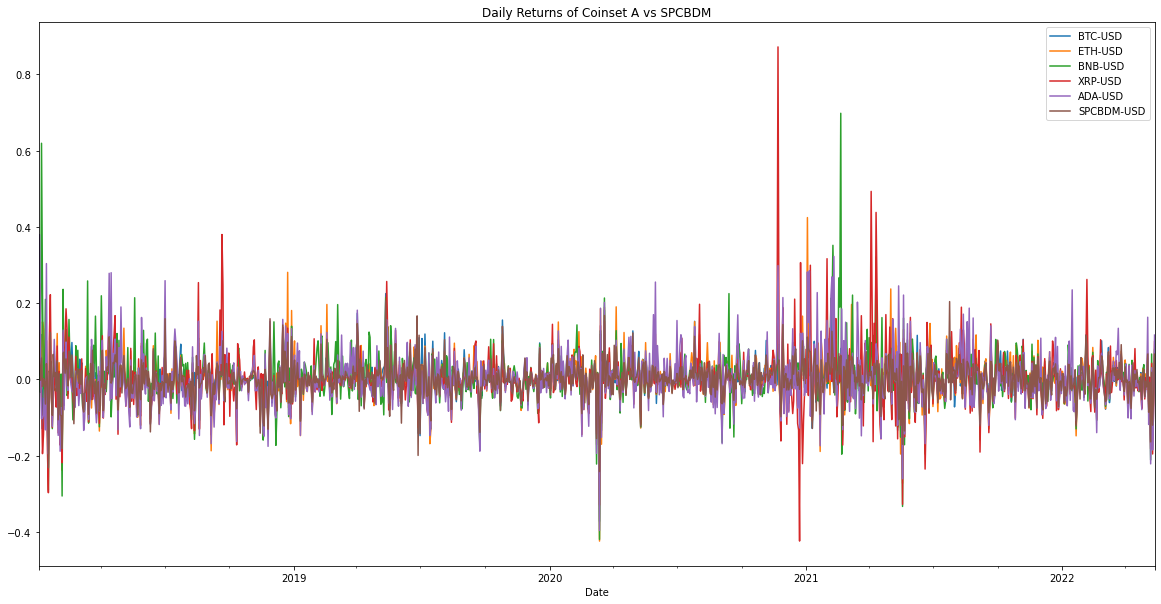

In [106]:
# Plotting the Daily Returns of Coinset A (Veteran Coins) vs the Index 

df_daily_returns.head()
df_daily_returns.plot(figsize=(20, 10), title= "Daily Returns of Coinset A vs SPCBDM")

### Preparing DataFrames for Analysis: Coinset: B

In [107]:
# Variables
yearly_trading_days = 365 # For Crypto

# Data Frames Needed
#    1. Daily Returns
#    2. Average Annual Returns
#    3. Standard Deviation of Daily Returns
#    4. Sharpe Ratios
#    5. Correlation 


# Daily Returns: percentage_change
df_daily_returns2 = concat_adj_close_df2.pct_change()
df_daily_returns2 = df_daily_returns2.dropna()


# Avg Annual Returns
avg_annual_return2 = df_daily_returns2.mean() * yearly_trading_days
avg_annual_return2.sort_values()


# Annual Returns STDDEV
df_daily_returns_stddev2 = df_daily_returns2.std() * np.sqrt(yearly_trading_days)
df_daily_returns_stddev2.sort_values()


#Sharpe Ratios
sharpe_ratios2 = avg_annual_return2/df_daily_returns_stddev2
sharpe_ratios2.sort_values()


# Sharpe Graphs
sharpe_ratios2.sort_values().hvplot.bar(
    hover_color='red',
    title="Coin Portfolio B & SPCBDM Sharpe Ratios"
).opts(
    width=700,
    yformatter='%.0f',
    #color="yellow",
    bgcolor="yellow",
    fontsize={
        'title': 15, 
        'labels': 12, 
    'xticks': 10, 
    'yticks': 10,},
    padding=0.1
)

:Bars   [index]   (0)

<AxesSubplot:title={'center':'Daily Returns of Coinset B vs SPCBDM'}, xlabel='Date'>

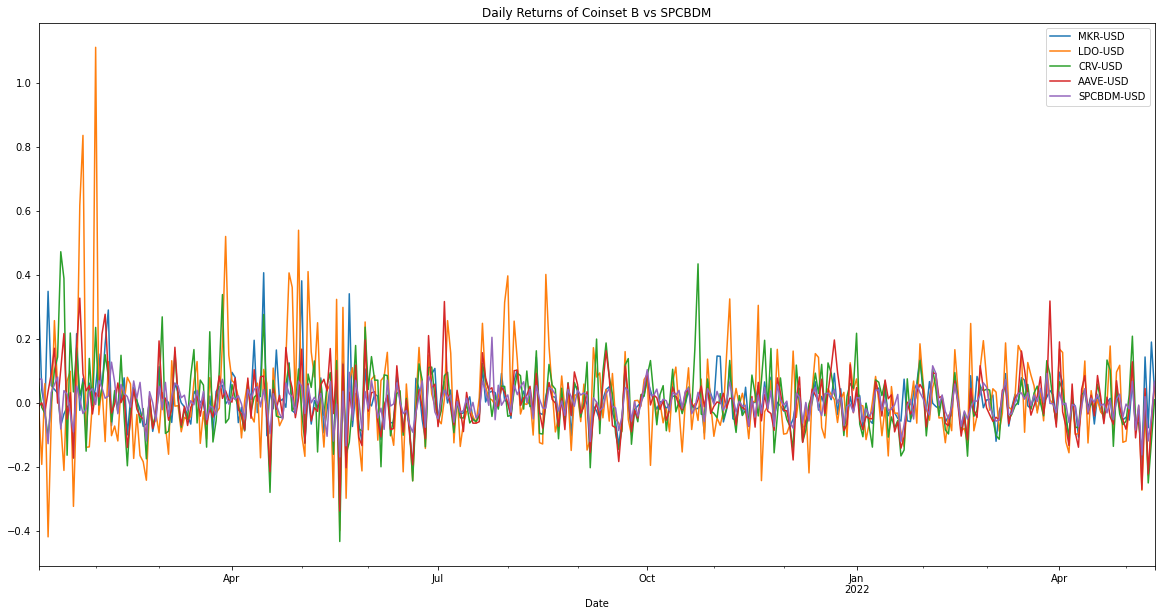

In [108]:
# Plotting the Daily Returns of Coinset A (Veteran Coins) vs the Index 

df_daily_returns2.head()
df_daily_returns2.plot(figsize=(20, 10), title= "Daily Returns of Coinset B vs SPCBDM")

## Brief Note on Correlation

<div class="alert alert-block alert-info">
<b>Correlation</b> 
<p>We use the Seaborn library to generate correlation maps of our coins. It should be noted that positively 
correlated coins tend to move together, negatively correlated variables move inversely to each other, 
and uncorrelated variables move independently of each other. It's common investing advise to have a mix
of assets positive negative and no correlation to mitigate risk.</p>
</div>

**Coinset A**

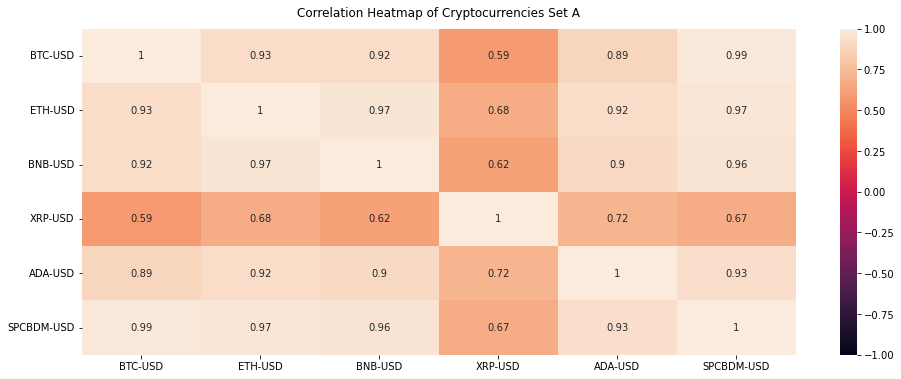

In [109]:
corr_df = concat_adj_close_df.corr(method='pearson')

#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()

#del corr_df.index.name
corr_df.head(10)

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Cryptocurrencies Set A', fontdict={'fontsize':12}, pad=12);

**Coinset B**

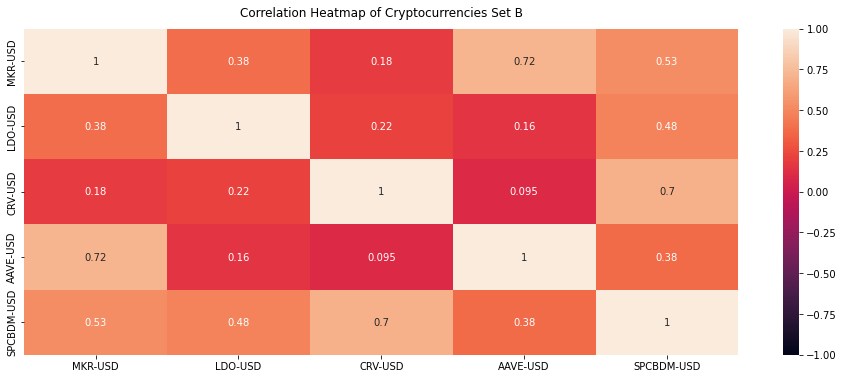

In [110]:
corr_df2 = concat_adj_close_df2.corr(method='pearson')

#reset symbol as index (rather than 0-X)
corr_df2.head().reset_index()

#del corr_df.index.name
corr_df2.head(10)

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df2, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Cryptocurrencies Set B', fontdict={'fontsize':12}, pad=12);

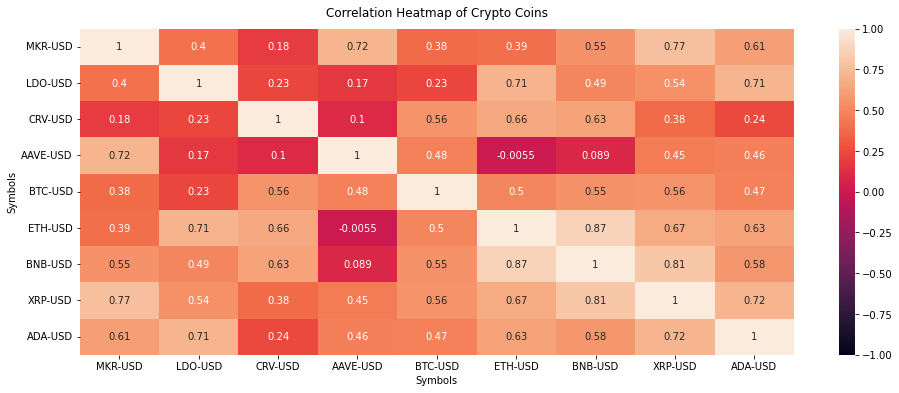

In [113]:
corr_crypto_df = concat_adj_close_df3.corr(method='pearson')

#reset symbol as index (rather than 0-X)
corr_crypto_df.head().reset_index()

#del corr_df.index.name
corr_crypto_df.head(10)

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_crypto_df, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Crypto Coins', fontdict={'fontsize':12}, pad=12);


## Measure Cumulative Returns of each Set

***CoinSet A***

In [114]:
cumulative_dailyrtn = (1 + df_daily_returns).cumprod()
cumulative_dailyrtn.tail()


,BTC-USD,ETH-USD,BNB-USD,XRP-USD,ADA-USD,SPCBDM-USD
Date,,,,,,
2022-05-09,2.218,2.906,35.575,0.206,0.837,1.634
2022-05-10,2.272,3.033,37.949,0.215,0.863,1.665
2022-05-11,2.119,2.682,32.083,0.173,0.704,1.465
2022-05-12,2.127,2.539,32.017,0.161,0.650,1.398
2022-05-13,2.144,2.607,34.533,0.177,0.726,1.491


<AxesSubplot:title={'center':'Cumulative Retruns of Coinset A vs SPCBDM'}, xlabel='Date'>

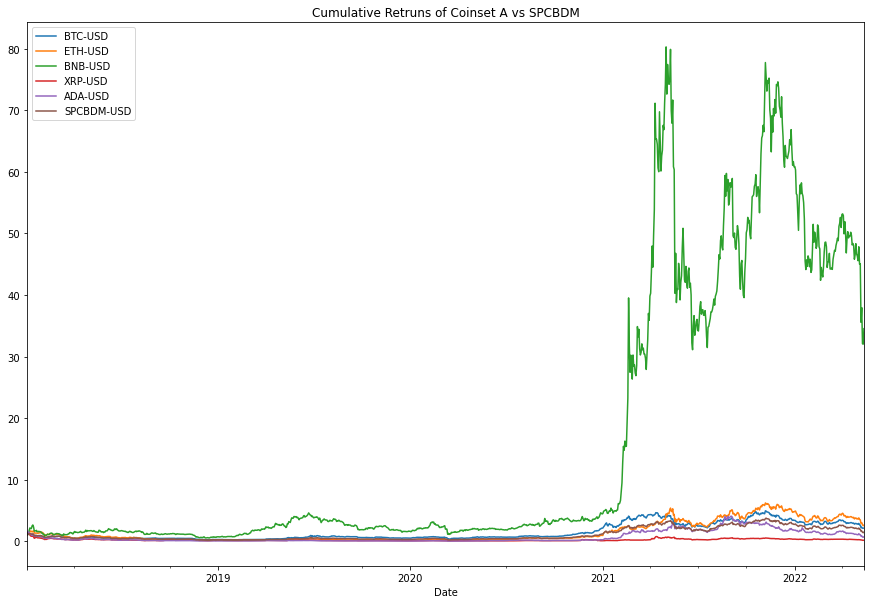

In [115]:
cumulative_dailyrtn.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset A vs SPCBDM")

***Coinset B***

In [116]:
cumulative_dailyrtn2 = (1 + df_daily_returns2).cumprod()
cumulative_dailyrtn2.tail()

,MKR-USD,LDO-USD,CRV-USD,AAVE-USD,SPCBDM-USD
Date,,,,,
2022-05-09,1.400,1.149,2.804,0.866,1.149
2022-05-10,1.599,1.118,2.885,0.905,1.170
2022-05-11,1.474,0.864,2.162,0.703,1.030
2022-05-12,1.753,0.801,1.904,0.666,0.983
2022-05-13,1.813,0.843,1.921,0.706,1.048


<AxesSubplot:title={'center':'Cumulative Retruns of Coinset B vs SPCBDM'}, xlabel='Date'>

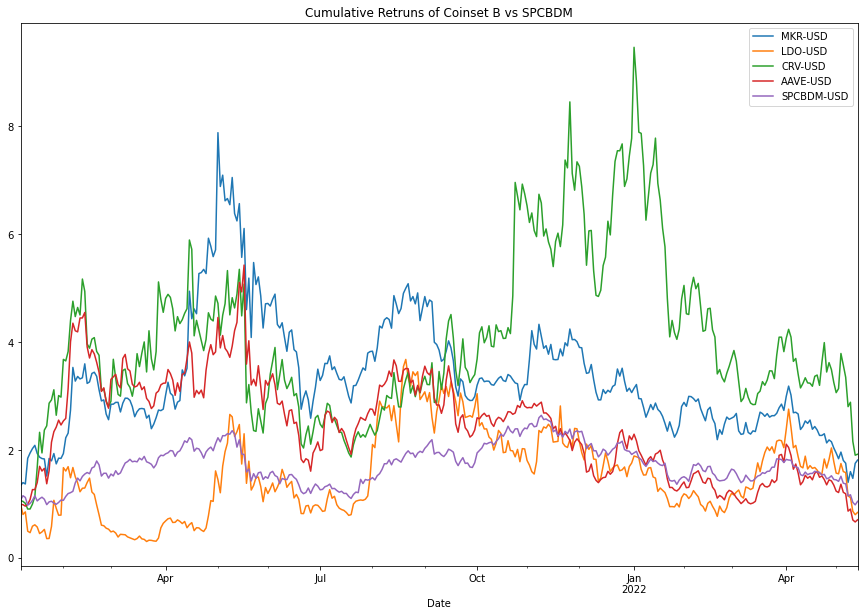

In [117]:
cumulative_dailyrtn2.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset B vs SPCBDM")

## Measure Volatility of each Set vs Index

<div class="alert alert-block alert-info">
    <b>Assumption of a Normal Distributuon</b>
<p>The performance data should follow a normal distribution for standard deviation to measure risk
accurately. In graphical terms, a normal distribution of data will plot on a chart resembling a 
bell-shaped curve. The histogram plots the proportion of observations within a host of category 
ranges. and allows us to see if the assumption that the performance data follows a normal distribution</p>
    </div>

/Users/comdrpaquiot/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  


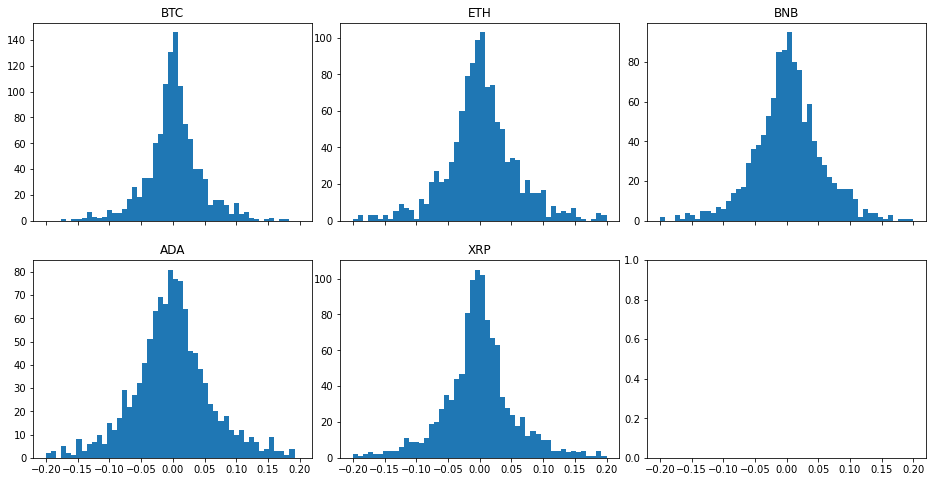

In [135]:
#ploting the histogram
fig, axs = plt.subplots(2,3,'all',figsize=(16,8),gridspec_kw ={'hspace': 0.2, 'wspace': 0.1})
axs[0,0].hist(df_daily_returns['BTC-USD'], bins=50, range=(-0.2, 0.2))
axs[0,0].set_title('BTC')
axs[0,1].hist(df_daily_returns['ETH-USD'], bins=50, range=(-0.2, 0.2))
axs[0,1].set_title('ETH')
axs[1,0].hist(df_daily_returns['ADA-USD'], bins=50, range=(-0.2, 0.2))
axs[1,0].set_title('ADA')
axs[1,1].hist(df_daily_returns['XRP-USD'], bins=50, range=(-0.2, 0.2))
axs[1,1].set_title('XRP')
axs[0,2].hist(df_daily_returns['BNB-USD'], bins=50, range=(-0.2, 0.2))
axs[0,2].set_title('BNB')
plt.show()

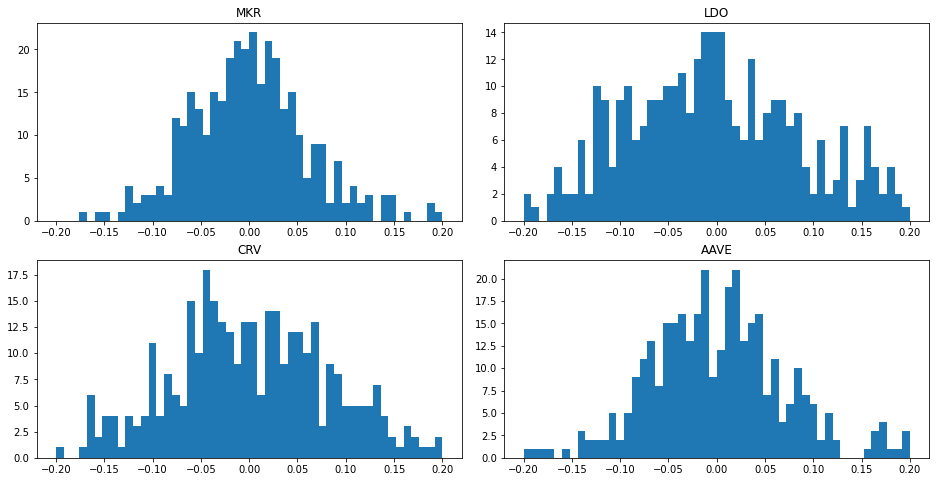

In [129]:
#ploting the histogram
fig, axs = plt.subplots(2,2,figsize=(16,8),gridspec_kw ={'hspace': 0.2, 'wspace': 0.1})
axs[0,0].hist(df_daily_returns2['MKR-USD'], bins=50, range=(-0.2, 0.2))
axs[0,0].set_title('MKR')
axs[0,1].hist(df_daily_returns2['LDO-USD'], bins=50, range=(-0.2, 0.2))
axs[0,1].set_title('LDO')
axs[1,0].hist(df_daily_returns2['CRV-USD'], bins=50, range=(-0.2, 0.2))
axs[1,0].set_title('CRV')
axs[1,1].hist(df_daily_returns2['AAVE-USD'], bins=50, range=(-0.2, 0.2))
axs[1,1].set_title('AAVE')
plt.show()

In [ ]:
#Comment: I think its interesting to see that Group Set B doesnt fit the Normal Distribution as tightly
# as group A

In [118]:
std_pfA = df_daily_returns.std().sort_values()

std_pfA

BTC-USD      0.046
SPCBDM-USD   0.047
ETH-USD      0.060
BNB-USD      0.070
ADA-USD      0.071
XRP-USD      0.074
dtype: float64

In [119]:
df_daily_returns_stddev.sort_values()

BTC-USD      0.874
SPCBDM-USD   0.902
ETH-USD      1.145
BNB-USD      1.330
ADA-USD      1.365
XRP-USD      1.409
dtype: float64

<AxesSubplot:title={'center':'Daily Volatility of Set A vs SPCBDM'}>

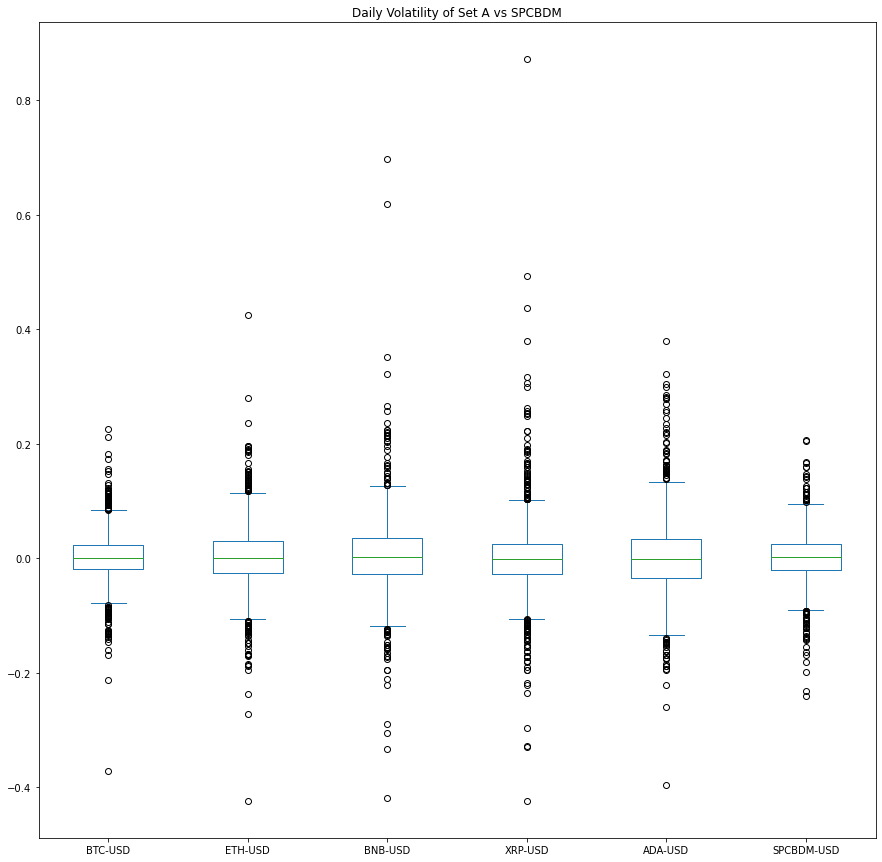

In [120]:
df_daily_returns.plot(kind="box", legend="True", figsize=(15, 15), title= "Daily Volatility of Set A vs SPCBDM")

In [122]:
std_pfB = df_daily_returns2.std().sort_values()

std_pfB

SPCBDM-USD   0.048
MKR-USD      0.080
AAVE-USD     0.084
CRV-USD      0.103
LDO-USD      0.152
dtype: float64

In [123]:
df_daily_returns_stddev2.sort_values()

SPCBDM-USD   0.912
MKR-USD      1.523
AAVE-USD     1.608
CRV-USD      1.967
LDO-USD      2.908
dtype: float64

<AxesSubplot:title={'center':'Daily Volatility of Set B vs SPCBDM'}>

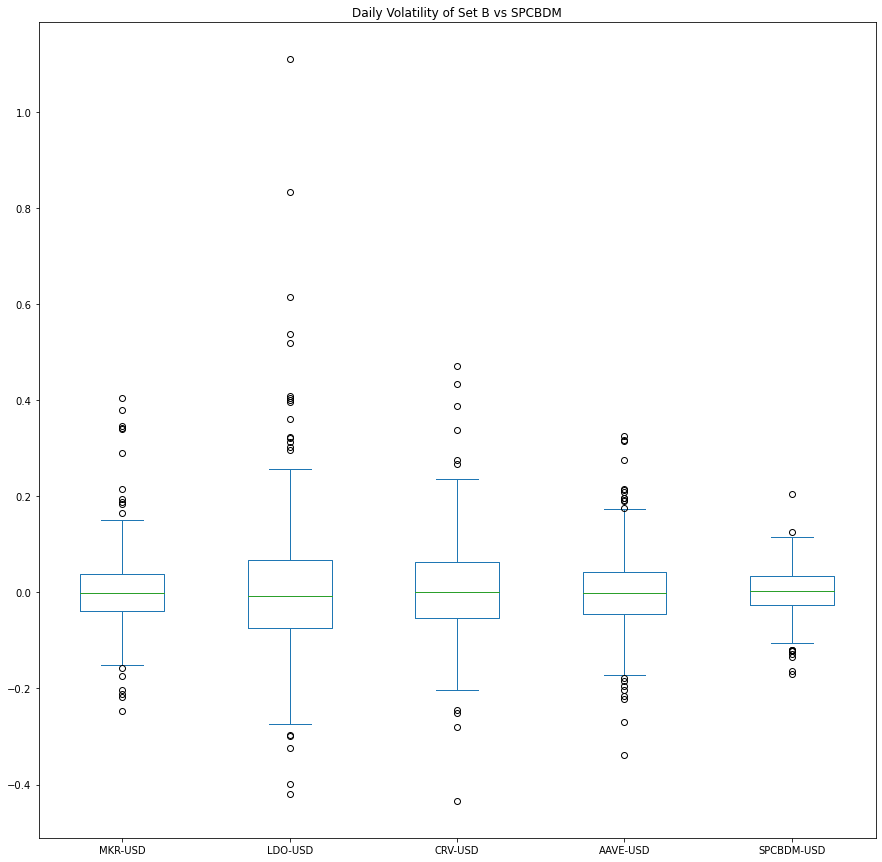

In [124]:
df_daily_returns2.plot(kind="box", legend="True", figsize=(15, 15), title= "Daily Volatility of Set B vs SPCBDM")

<AxesSubplot:title={'center':'21-Day Rolling Std Deviation Set A'}, xlabel='Date'>

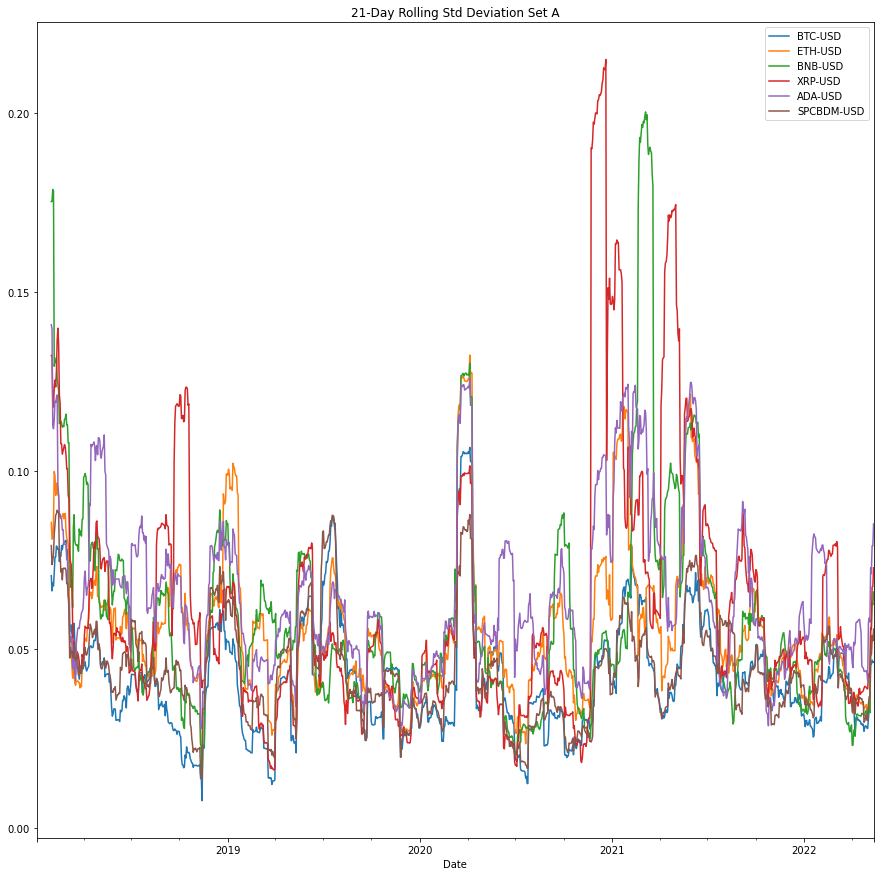

In [125]:
df_daily_returns.rolling(window=21).std().plot(legend="True", figsize=(15, 15), title= "21-Day Rolling Std Deviation Set A")

<AxesSubplot:title={'center':'21-Day Rolling Std Deviation Set B'}, xlabel='Date'>

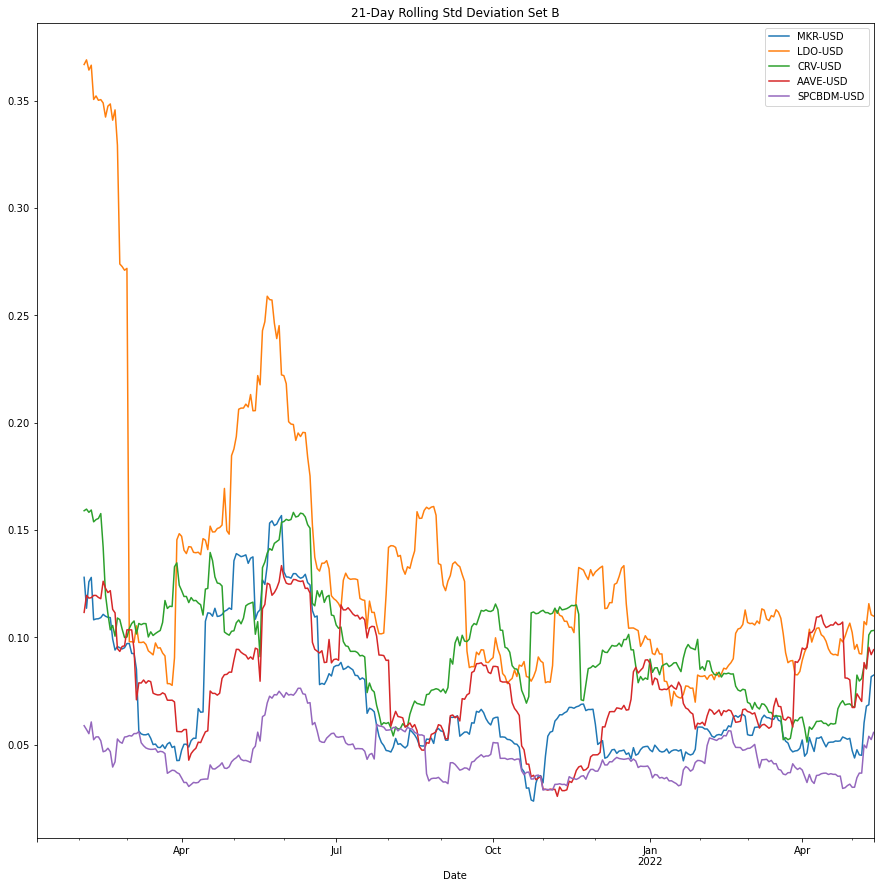

In [126]:
df_daily_returns2.rolling(window=21).std().plot(legend="True", figsize=(15, 15), title= "21-Day Rolling Std Deviation Set B")

## Daily returns of our Coin Sets vs the SPCBDM Index

In [136]:
# Calculating the Daily Returns of Coinset A (Veteran Coins) vs the Index. Dropping all NAN values 

daily_returns_1 = concat_adj_close_df.pct_change().dropna()
daily_returns_1.head()

,BTC-USD,ETH-USD,BNB-USD,XRP-USD,ADA-USD,SPCBDM-USD
Date,,,,,,
2018-01-02,0.097,0.145,0.050,0.038,0.074,0.122
2018-01-03,0.015,0.089,0.079,0.252,0.380,0.043
2018-01-04,0.026,0.019,-0.034,0.029,0.032,-0.002
2018-01-05,0.117,0.017,0.619,-0.046,-0.103,0.056
2018-01-08,-0.130,0.151,0.224,-0.194,-0.101,-0.019


<AxesSubplot:title={'center':'Daily Returns of CoinsetA vs SPCBDM'}, xlabel='Date'>

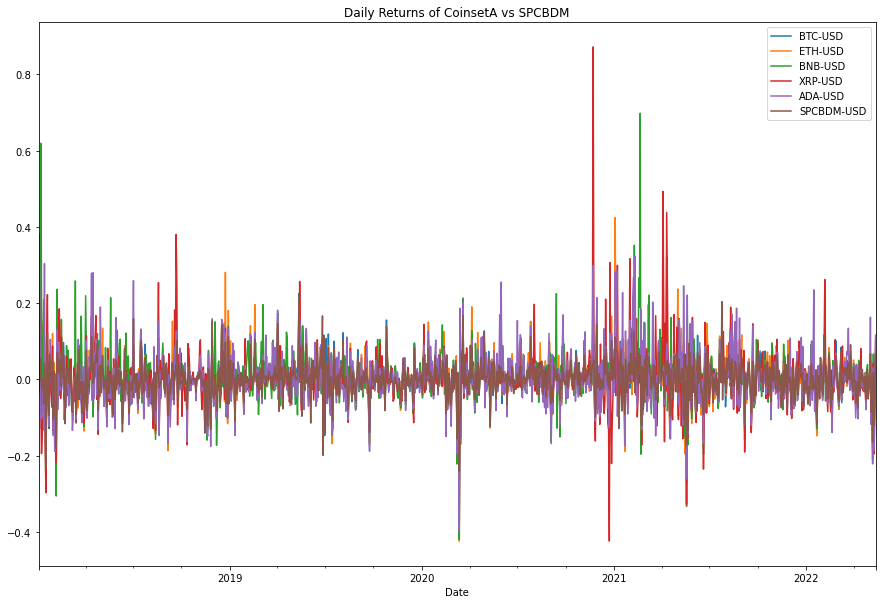

In [137]:
# Plotting the Daily Returns of Coinset A (Veteran Coins) vs the Index 

daily_returns_1.plot(figsize=(15, 10), title= "Daily Returns of CoinsetA vs SPCBDM")

In [138]:
# Calculating the Cumulative Returns for Coinset A (Veteran Coins) vs the Index 

cumulative_dailyrtn = (1 + daily_returns_1).cumprod()
cumulative_dailyrtn.tail()


,BTC-USD,ETH-USD,BNB-USD,XRP-USD,ADA-USD,SPCBDM-USD
Date,,,,,,
2022-05-09,2.218,2.906,35.575,0.206,0.837,1.634
2022-05-10,2.272,3.033,37.949,0.215,0.863,1.665
2022-05-11,2.119,2.682,32.083,0.173,0.704,1.465
2022-05-12,2.127,2.539,32.017,0.161,0.650,1.398
2022-05-13,2.144,2.607,34.533,0.177,0.726,1.491


<AxesSubplot:title={'center':'Cumulative Retruns of Coinset A vs SPCBDM'}, xlabel='Date'>

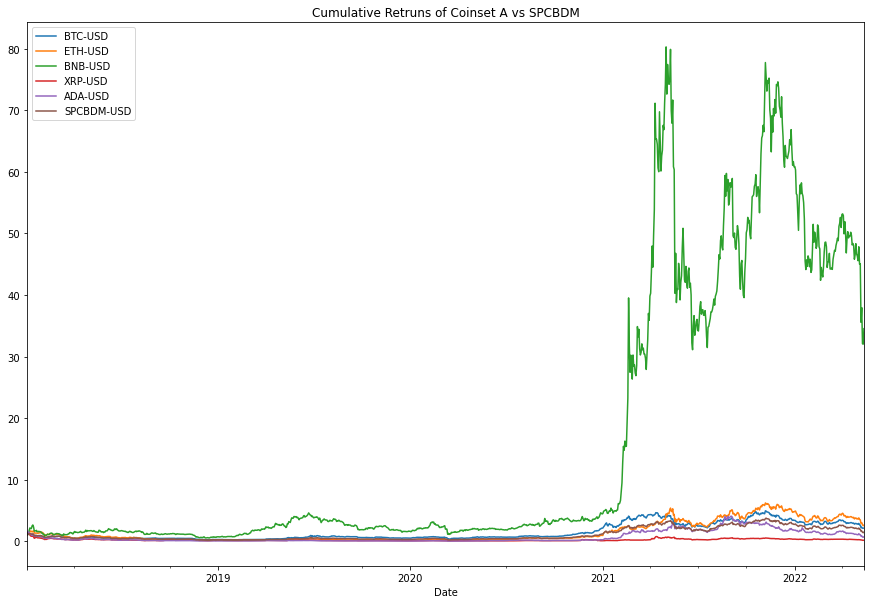

In [139]:
# Plotting the Cumulative Returns for Coinset A vs the Index 

cumulative_dailyrtn.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset A vs SPCBDM")

# Our coins show that they would have outperformed the index, partly due to BNB's run up during 2021. 

In [142]:
# Calculating the average annual return for Coinset A (Veteran Coins)

avg_anl_rtn = daily_returns_1.mean() * 252
avg_anl_rtn.sort_values()

XRP-USD      0.269
SPCBDM-USD   0.373
BTC-USD      0.438
ADA-USD      0.562
ETH-USD      0.670
BNB-USD      1.374
dtype: float64

In [143]:
dict_coinsA = {
    'XRP-USD': avg_anl_rtn['XRP-USD'],
    'SPCBDM-USD': avg_anl_rtn['SPCBDM-USD'],
    'BTC-USD': avg_anl_rtn['BTC-USD'],
    'ADA-USD': avg_anl_rtn['ADA-USD'],
    'ETH-USD': avg_anl_rtn['ETH-USD'],
    'BNB-USD': avg_anl_rtn['BNB-USD']}

print(dict_coinsA)

{'XRP-USD': 0.26913535906612024, 'SPCBDM-USD': 0.3731002756687785, 'BTC-USD': 0.4379322590210465, 'ADA-USD': 0.5615277783099991, 'ETH-USD': 0.6696653327279558, 'BNB-USD': 1.3742255229244957}


In [144]:
df_coins = pd.DataFrame.from_dict({'coin': list(dict_coinsA.keys()), 'rtns': list(dict_coinsA.values())})
display(df_coins.head())

,coin,rtns
0,XRP-USD,0.269
1,SPCBDM-USD,0.373
2,BTC-USD,0.438
3,ADA-USD,0.562
4,ETH-USD,0.670


In [145]:
val_index = df_coins.index[df_coins['coin']=='SPCBDM-USD']
value = df_coins.iloc[1]['rtns']
display(f" We want the returns to be greater than: SPCBDM value: {value}")
criteria = df_coins[df_coins.iloc[:, 1] > value]
display(criteria)

' We want the returns to be greater than: SPCBDM value: 0.3731002756687785'

,coin,rtns
2,BTC-USD,0.438
3,ADA-USD,0.562
4,ETH-USD,0.670
5,BNB-USD,1.374


# BTC , ADA, ETH, BNB all offered better returns than the index! 
 Now to Coinset B

In [146]:
# Calculating the Daily Returns of Coinset B (Veteran Coins) vs the Index . Dropping all NAN values 

daily_returns_2 = concat_adj_close_df2.pct_change().dropna()
daily_returns_2.head()

,MKR-USD,LDO-USD,CRV-USD,AAVE-USD,SPCBDM-USD
Date,,,,,
2021-01-06,0.343,-0.003,0.062,-0.012,0.073
2021-01-07,0.040,-0.193,-0.014,-0.001,0.074
2021-01-08,-0.018,0.059,-0.034,-0.028,-0.027
2021-01-11,0.348,-0.419,-0.105,0.035,-0.128
2021-01-12,0.053,-0.055,0.001,0.090,0.032


<AxesSubplot:title={'center':'Daily Returns of CoinsetB vs SPCBDM'}, xlabel='Date'>

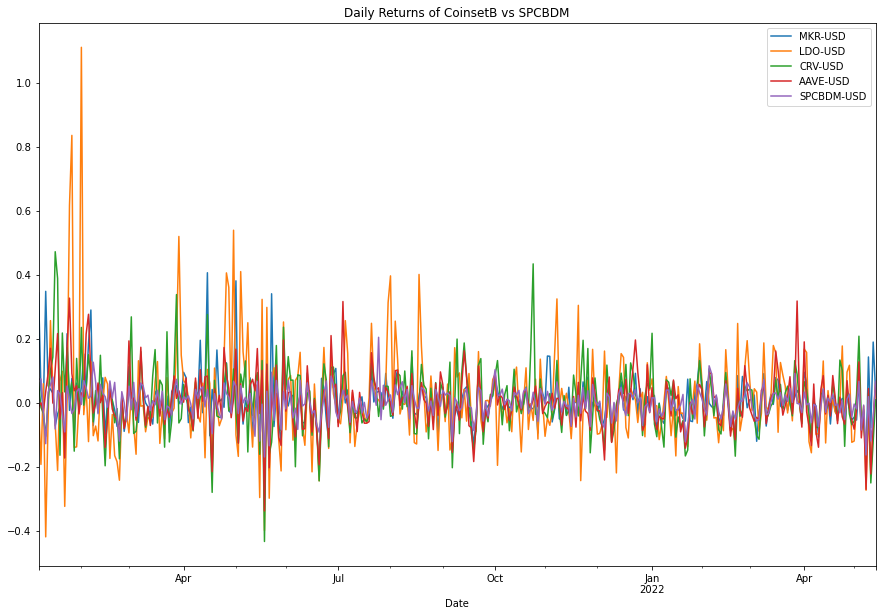

In [147]:
# Plotting the Daily Returns of Coinset B (DeFi Coins) vs the Index 

daily_returns_2.plot(figsize=(15, 10), title= "Daily Returns of CoinsetB vs SPCBDM")

In [148]:
# Calculating the Cumulative Returns of Coinset B (DeFi Coins) vs the Index

cumulative_dailyrtn2 = (1 + daily_returns_2).cumprod()
cumulative_dailyrtn2.tail()


,MKR-USD,LDO-USD,CRV-USD,AAVE-USD,SPCBDM-USD
Date,,,,,
2022-05-09,1.400,1.149,2.804,0.866,1.149
2022-05-10,1.599,1.118,2.885,0.905,1.170
2022-05-11,1.474,0.864,2.162,0.703,1.030
2022-05-12,1.753,0.801,1.904,0.666,0.983
2022-05-13,1.813,0.843,1.921,0.706,1.048


<AxesSubplot:title={'center':'Cumulative Retruns of Coinset B vs SPCBDM'}, xlabel='Date'>

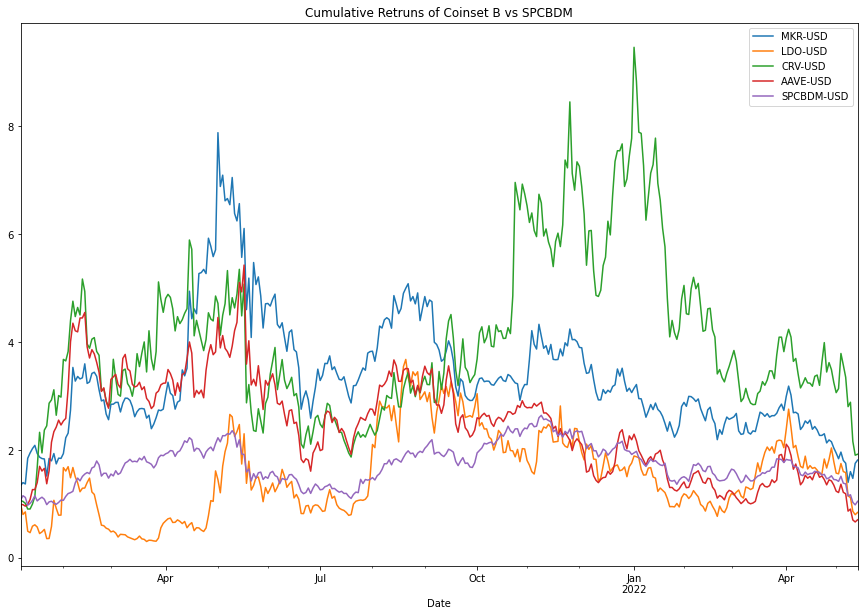

In [149]:
# Plotting the Cumulative Returns of Coinset B (DeFi Coins) vs the Index


cumulative_dailyrtn2.plot(legend="True", figsize=(15, 10), title= "Cumulative Retruns of Coinset B vs SPCBDM")

In [150]:
# Calculating the Average annual return of the DeFi set of coins

avg_anl_rtn2 = daily_returns_2.mean() * 252
avg_anl_rtn2.sort_values()

SPCBDM-USD   0.323
AAVE-USD     0.637
MKR-USD      1.183
CRV-USD      1.783
LDO-USD      2.455
dtype: float64

In [153]:
dict_coinsB = {
    'CRV-USD': avg_anl_rtn2['CRV-USD'],
    'SPCBDM-USD': avg_anl_rtn2['SPCBDM-USD'],
    'LDO-USD': avg_anl_rtn2['LDO-USD'],
    'MKR-USD': avg_anl_rtn2['MKR-USD'],
    'AAVE-USD': avg_anl_rtn2['AAVE-USD']}

print(dict_coinsB)

{'CRV-USD': 1.7830899635160797, 'SPCBDM-USD': 0.3234695879132228, 'LDO-USD': 2.454574230845933, 'MKR-USD': 1.1829318666742736, 'AAVE-USD': 0.6370799154032388}


In [154]:
df_coins = pd.DataFrame.from_dict({'coin': list(dict_coinsB.keys()), 'rtns': list(dict_coinsB.values())})
display(df_coins.head())

,coin,rtns
0,CRV-USD,1.783
1,SPCBDM-USD,0.323
2,LDO-USD,2.455
3,MKR-USD,1.183
4,AAVE-USD,0.637


In [155]:
val_index = df_coins.index[df_coins['coin']=='SPCBDM-USD']
value = df_coins.iloc[1]['rtns']
display(f" We want the returns to be greater than: SPCBDM value: {value}")
criteria = df_coins[df_coins.iloc[:, 1] > value]
display(criteria)

' We want the returns to be greater than: SPCBDM value: 0.3234695879132228'

,coin,rtns
0,CRV-USD,1.783
2,LDO-USD,2.455
3,MKR-USD,1.183
4,AAVE-USD,0.637


# CURVE , LIDO and CONVEX FINANCE offered a better return that the index! 
 Next - We kept the coins that preformed better than the index:

In [156]:
# Creating a dataframe with the final selection of coins that outperformed the index 

coinset_list3 = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'BNB-USD', 'CRV-USD', 'CVX-USD', 'LDO-USD'] 

final_list = cn_close_price_dfer(coinset_list3)

concat_final = pd.concat([final_list, spcbdm_indx], axis=1)

sim_list = final_list.dropna()
sim_index = spcbdm_indx.dropna()

display(sim_list.dropna().head())
display(concat_final.dropna().head())

Symbols,BTC-USD,ETH-USD,ADA-USD,BNB-USD,CRV-USD,CVX-USD,LDO-USD
Date,,,,,,,
2021-05-18,42909.402,3380.070,2.004,508.022,3.488,9.079,4.056
2021-05-19,37002.441,2460.679,1.483,339.025,1.975,6.164,2.436
2021-05-20,40782.738,2784.294,1.810,393.613,2.208,7.308,3.161
2021-05-21,37304.691,2430.621,1.552,326.296,1.851,5.780,2.217
2021-05-22,37536.633,2295.706,1.464,299.504,1.625,5.657,1.975


,BTC-USD,ETH-USD,ADA-USD,BNB-USD,CRV-USD,CVX-USD,LDO-USD,SPCBDM-USD
Date,,,,,,,,
2021-05-18,42909.402,3380.070,2.004,508.022,3.488,9.079,4.056,4508.390
2021-05-19,37002.441,2460.679,1.483,339.025,1.975,6.164,2.436,3743.390
2021-05-20,40782.738,2784.294,1.810,393.613,2.208,7.308,3.161,3876.760
2021-05-21,37304.691,2430.621,1.552,326.296,1.851,5.780,2.217,3354.100
2021-05-24,38705.980,2643.591,1.549,345.310,1.622,6.411,2.368,3672.130


In [157]:
cols = pd.MultiIndex.from_tuples([('BTC-USD', 'close'),
                                  ('ETH-USD', 'close'),
                                  ('ADA-USD', 'close'),
                                  ('BNB-USD', 'close'),
                                  ('CRV-USD', 'close'),
                                  ('CVX-USD', 'close'),
                                  ('LDO-USD', 'close')])
                            
                        


In [158]:
sim_list.columns = cols

In [159]:
pfsim = MCSimulation(
    portfolio_data = sim_list,
    num_simulation =1000,
    weights = [.16, .14, .14, .14, .14, .14,.14],
    num_trading_days = 365
)

NameError: name 'MCSimulation' is not defined

In [ ]:
pfsim.portfolio_data.head()

In [277]:
pfsim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\barkf\Fintech2022jptr\project\Project-1-Files-main\Final\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1,0.982,0.962,0.967,1.027,1.040,1.002,0.997,0.981,1.029,0.970,...,1.004,1.015,1.001,1.018,1.011,0.927,1.020,1.027,0.975,1.001
2,1.013,0.940,0.983,1.035,1.032,1.016,1.008,0.974,1.048,0.993,...,0.986,1.068,0.980,0.981,1.037,0.907,1.022,1.020,1.002,1.022
3,0.996,0.957,1.012,1.022,0.991,1.057,1.022,0.953,1.067,0.996,...,1.015,1.112,0.993,0.968,1.047,0.929,0.986,1.031,1.073,1.048
4,1.013,0.960,1.033,1.010,0.963,1.045,1.001,0.940,1.068,0.983,...,0.993,1.170,1.022,0.972,1.081,0.919,1.001,0.972,1.030,0.986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,1.401,2.485,1.191,2.127,0.819,3.183,0.817,4.618,0.924,0.843,...,1.306,2.365,0.793,2.967,1.128,1.435,1.646,1.863,0.747,2.002
362,1.404,2.557,1.158,2.000,0.758,3.257,0.797,4.626,0.908,0.816,...,1.252,2.379,0.841,3.031,1.105,1.496,1.600,1.854,0.752,2.047
363,1.415,2.585,1.204,1.963,0.770,3.352,0.763,4.512,0.926,0.835,...,1.265,2.437,0.849,2.850,1.114,1.502,1.588,1.801,0.743,2.057
364,1.374,2.425,1.189,1.986,0.760,3.339,0.775,4.522,0.905,0.860,...,1.227,2.387,0.862,2.855,1.107,1.497,1.580,1.670,0.729,2.107


Next we ran a simulation for 1 year worth of returns:

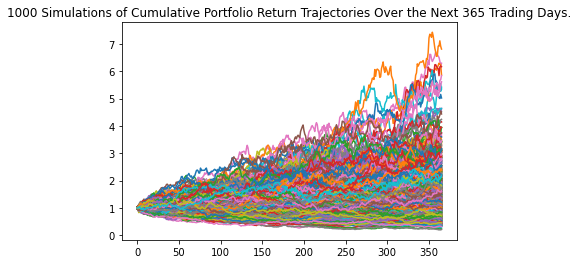

In [278]:
line_plot = pfsim.plot_simulation()

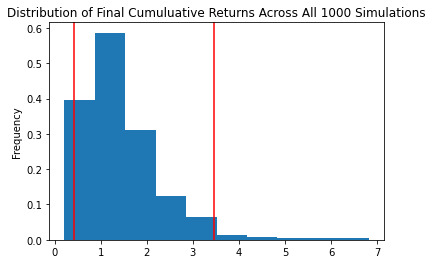

In [279]:
pfsim_dist = pfsim.plot_distribution()

In [280]:
sim_rtn_data = {
    "mean": list(pfsim.simulated_return.mean(axis=1)),
    "median": list(pfsim.simulated_return.median(axis=1)),
    "min": list(pfsim.simulated_return.min(axis=1)),
    "max": list(pfsim.simulated_return.max(axis=1))
}

sim_rtn = pd.DataFrame(sim_rtn_data)

# Sample data
sim_rtn.head()

,mean,median,min,max
0,1.000,1.000,1.000,1.000
1,1.001,1.002,0.912,1.083
2,1.003,1.004,0.830,1.125
3,1.006,1.005,0.847,1.190
4,1.005,1.002,0.835,1.237


<AxesSubplot:title={'center':'Simulated Daily Returns Behavior Of Our Coin Portfolio Over the Next Year'}>

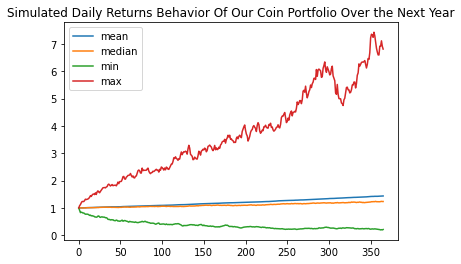

In [281]:
sim_rtn.plot(title="Simulated Daily Returns Behavior Of Our Coin Portfolio Over the Next Year")

Simulated Profits/Losses of $100,000 Investment in our Coin selection Over the Next 252 Trading Days

In [282]:
initial_investment = 100000

cumulative_pnl = initial_investment * sim_rtn

cumulative_pnl.head()

,mean,median,min,max
0,100000.000,100000.000,100000.000,100000.000
1,100137.523,100152.143,91205.332,108330.046
2,100347.743,100374.459,82978.200,112545.670
3,100595.939,100509.155,84662.149,118987.831
4,100488.956,100167.063,83525.210,123718.831


<AxesSubplot:title={'center':'Simulated Outcomes Behavior Of Our Coin Portfolio Over the Next Year'}>

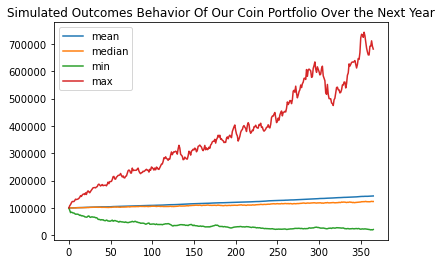

In [283]:
cumulative_pnl.plot(title="Simulated Outcomes Behavior Of Our Coin Portfolio Over the Next Year")

In [284]:
tbl = pfsim.summarize_cumulative_return()

# summary statistics
print(tbl)

count          1000.000
mean              1.439
std               0.847
min               0.213
25%               0.859
50%               1.237
75%               1.754
max               6.811
95% CI Lower      0.433
95% CI Upper      3.451
Name: 365, dtype: float64


In [285]:
ci_lower = round(tbl[8]*100000,2)
ci_upper = round(tbl[9]*100000,2)

# results
print(f"There is a 95% chance that an initial investment of $100,000 in the portfolio"
      f" over the next year will end within the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $100,000 in the portfolio over the next year will end within the range of $43306.06 and $345077.18.


# Now we repeat for our Index  
There will be no notes as the process is the same

In [286]:
cols2 = pd.MultiIndex.from_tuples([('SPCBDM-USD', 'close')])

spcbdm_indx.columns = cols2

In [304]:
indxsim = MCSimulation(
    portfolio_data = spcbdm_indx,
    num_simulation =1000,
    weights = [1],
    num_trading_days = 365
)

In [305]:
indxsim.portfolio_data.head()

SPCBDM-USD             
                close daily_return
Date                              
2021-05-13   4828.860          NaN
2021-05-14   5148.730        0.066
2021-05-17   4530.050       -0.120
2021-05-18   4508.390       -0.005
2021-05-19   3743.390       -0.170

In [306]:
indxsim.calc_cumulative_return() 

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\barkf\Fintech2022jptr\project\Project-1-Files-main\Final\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1,0.997,0.991,0.950,0.953,1.078,1.003,1.064,0.855,1.038,0.966,...,0.937,0.988,0.845,0.993,1.009,0.987,1.013,1.039,1.040,1.008
2,0.988,0.993,0.943,0.936,1.072,0.958,1.085,0.855,1.019,0.917,...,0.965,1.026,0.893,0.956,0.907,0.982,0.960,1.005,0.954,0.935
3,1.020,0.998,0.881,0.923,1.078,0.950,1.111,0.880,1.017,0.889,...,0.995,1.076,0.936,0.926,0.872,1.010,0.940,1.059,0.970,0.974
4,1.085,0.967,0.813,0.951,1.067,0.918,1.181,0.890,1.060,0.910,...,0.976,1.055,0.930,0.879,0.897,0.953,0.933,0.999,0.991,0.984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.611,0.689,0.093,0.123,0.354,0.416,0.324,1.191,0.732,0.920,...,0.592,0.213,0.310,0.214,0.283,0.062,0.234,0.363,0.675,0.820
362,0.626,0.716,0.094,0.113,0.368,0.411,0.326,1.237,0.737,1.023,...,0.598,0.207,0.325,0.212,0.299,0.063,0.232,0.371,0.714,0.813
363,0.652,0.784,0.101,0.109,0.370,0.405,0.325,1.199,0.706,0.934,...,0.596,0.212,0.333,0.196,0.303,0.066,0.244,0.386,0.750,0.852
364,0.631,0.821,0.107,0.115,0.371,0.426,0.326,1.230,0.682,0.938,...,0.626,0.195,0.323,0.207,0.291,0.066,0.238,0.377,0.689,0.886


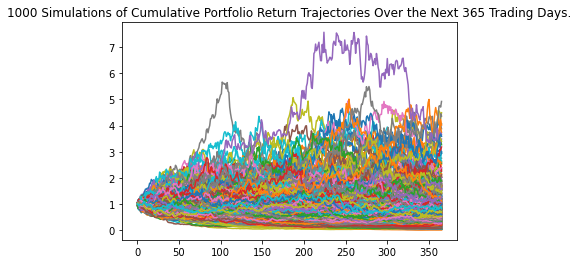

In [307]:
line_plot = indxsim.plot_simulation()

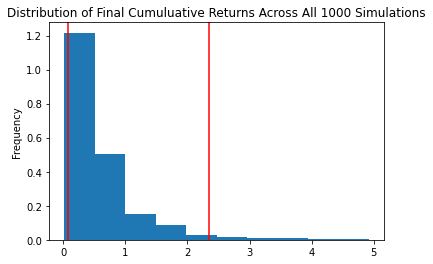

In [308]:
pfsim_dist = indxsim.plot_distribution() 


In [309]:
sim_rtn_data2 = {
    "mean": list(indxsim.simulated_return.mean(axis=1)),
    "median": list(indxsim.simulated_return.median(axis=1)),
    "min": list(indxsim.simulated_return.min(axis=1)),
    "max": list(indxsim.simulated_return.max(axis=1))
}

sim_rtn2 = pd.DataFrame(sim_rtn_data2)

# Sample data for index
sim_rtn2.head()

,mean,median,min,max
0,1.000,1.000,1.000,1.000
1,0.998,0.998,0.816,1.166
2,0.995,0.992,0.781,1.199
3,0.994,0.992,0.757,1.228
4,0.992,0.990,0.711,1.323


<AxesSubplot:title={'center':'Simulated Daily Returns Behavior of our Index Over the Next Year'}>

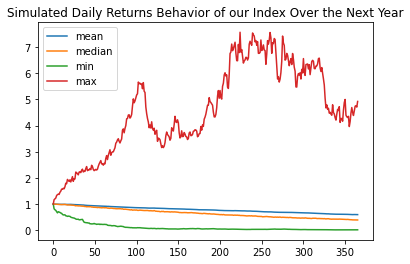

In [310]:
sim_rtn2.plot(title="Simulated Daily Returns Behavior of our Index Over the Next Year")

In [311]:
# 100,000 investment
cumulative_pnl2 = initial_investment * sim_rtn2

cumulative_pnl2.head()

,mean,median,min,max
0,100000.000,100000.000,100000.000,100000.000
1,99808.963,99763.909,81626.013,116600.361
2,99511.452,99209.541,78104.595,119905.416
3,99438.929,99214.916,75731.051,122792.931
4,99179.061,99021.129,71121.409,132256.468


<AxesSubplot:title={'center':'Simulated Outcomes Behavior Of Our Index Over the Next Year'}>

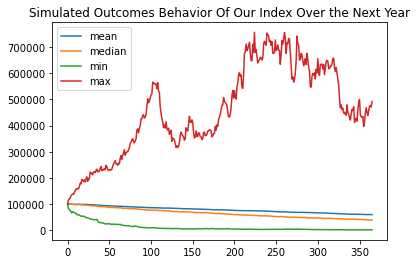

In [312]:
cumulative_pnl2.plot(title="Simulated Outcomes Behavior Of Our Index Over the Next Year")

In [313]:
tbl2 = indxsim.summarize_cumulative_return()

# summary statistics
print(tbl2)

count          1000.000
mean              0.596
std               0.623
min               0.014
25%               0.217
50%               0.390
75%               0.736
max               4.922
95% CI Lower      0.067
95% CI Upper      2.352
Name: 365, dtype: float64


In [314]:
ci_lower2 = round(tbl2[8]*100000,2)
ci_upper2 = round(tbl2[9]*100000,2)

# results
print(f"There is a 95% chance that an initial investment of $100,000 in the index"
      f" over the next year will end within the range of"
      f" ${ci_lower2} and ${ci_upper2}.")

There is a 95% chance that an initial investment of $100,000 in the index over the next year will end within the range of $6733.05 and $235207.39.


# Now for the conclusion statement:

In [316]:
if (ci_upper > ci_upper2) and (ci_lower > ci_lower2):
    print("As seen by our projections, the Coin Model has outperformed the Index")
else:
    print("The Index outperformed the coins")
    

As seen by our projections, the Coin Model has outperformed the Index


Note:
As crypto is traded 365 days, we used the same number for our index although it is only traded 252 days.
When using their actual trading days, our coin set model outperfomed the index significantly more.